<a href="https://colab.research.google.com/github/Andrea-1704/Pytorch_Geometric_tutorial/blob/main/train_model_baseline_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facciamo adesso un pre training che sia molto simile al task effettivo e che sia supervisionato sul dataset di training andando a cercare di predire non la posizione corretta per il posizionamento di un pilota in una gara, ma piuttosto una categoria più semplice da predire.

Categoria	Condizione

0	Vincitore → positionOrder == 1

1	Podio → positionOrder == 2 or 3

2	Top10 → positionOrder >= 4 and <= 10

3	Finisher dopo 10° → positionOrder > 10

4	Ritirato o status anomalo → positionOrder == 0 oppure particolari statusId

In [2]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0
# !pip uninstall -y pyg_lib torch  # Uninstall current versions
# !pip install torch==2.6.0  # Reinstall your desired PyTorch version
# !pip install --no-cache-dir git+https://github.com/pyg-team/pyg-lib.git # Install pyg-lib; --no-cache-dir ensures a fresh install

New libraries to run on colab:

In [3]:
# !pip install torch==2.6.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.6.0+cu118.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0

In [4]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [5]:
import os
import torch
import relbench
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import math
from tqdm import tqdm
import torch_geometric
import torch_frame
from torch_geometric.seed import seed_everything
from relbench.modeling.utils import get_stype_proposal
from collections import defaultdict
import requests
from io import StringIO
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.graph import make_pkey_fkey_graph
from torch.nn import BCEWithLogitsLoss
import copy
from typing import Any, Dict, List
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from relbench.modeling.graph import get_node_train_table_input, make_pkey_fkey_graph
from torch_geometric.loader import NeighborLoader
import pyg_lib
from sklearn.metrics import mean_squared_error
#per lo scheduler
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import networkx as nx
#import os


# Dataset and task creation

In [6]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train")
val_table = task.get_table("val")
test_table = task.get_table("test")

out_channels = 1
# one because we are estimating one single value.
loss_fn = L1Loss()
# this is the mae loss and is used when have regressions tasks.
tune_metric = "mae"
higher_is_better = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
root_dir = "./data"

db = dataset.get_db()
col_to_stype_dict = get_stype_proposal(db)
#this is used to get the stype of the columns

100%|████████████████████████████████████████| 704k/704k [00:00<00:00, 488MB/s]
Unzipping contents of '/root/.cache/relbench/rel-f1/db.zip' to '/root/.cache/relbench/rel-f1/.'
100%|█████████████████████████████████████| 36.5k/36.5k [00:00<00:00, 38.8MB/s]
Unzipping contents of '/root/.cache/relbench/rel-f1/tasks/driver-position.zip' to '/root/.cache/relbench/rel-f1/tasks/.'


cuda
Loading Database object from /root/.cache/relbench/rel-f1/db...
Done in 0.06 seconds.


# Embedder

In [7]:
# import torch
# from typing import List, Optional
# from sentence_transformers import SentenceTransformer
# from torch import Tensor


# class GloveTextEmbedding:
#     def __init__(self, device: Optional[torch.device
#                                        ] = None):
#         self.model = SentenceTransformer(
#             "sentence-transformers/average_word_embeddings_glove.6B.300d",
#             device=device,
#         )

#     def __call__(self, sentences: List[str]) -> Tensor:
#         return torch.from_numpy(self.model.encode(sentences))


class LightweightGloveEmbedder:
    def __init__(self, device=None):
        self.device = device
        self.embeddings = defaultdict(lambda: np.zeros(300))
        self._load_embeddings()

    def _load_embeddings(self):
        try:
            #(senza bisogno di estrarre zip
            url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.300d.txt"
            response = requests.get(url)
            response.raise_for_status()

            for line in StringIO(response.text):
                parts = line.split()
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)
                self.embeddings[word] = vector
        except Exception as e:
            print(f"Warning: Couldn't load GloVe embeddings ({str(e)}). Using zero vectors.")

    def __call__(self, sentences):
        results = []
        for text in sentences:
            words = text.lower().split()
            vectors = [self.embeddings[w] for w in words if w in self.embeddings]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                avg_vector = np.zeros(300)
            results.append(avg_vector)

        tensor = torch.tensor(np.array(results), dtype=torch.float32)
        return tensor.to(self.device) if self.device else tensor

In [8]:
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=LightweightGloveEmbedder(device=device), batch_size=256
)

data, col_stats_dict = make_pkey_fkey_graph(
    #Solution if not working: !pip install --upgrade torch torchvision transformers
    db,
    col_to_stype_dict=col_to_stype_dict,  # speficied column types
    text_embedder_cfg=text_embedder_cfg,  # our chosen text encoder
    cache_dir=os.path.join(
        root_dir, f"rel-f1_materialized_cache"
    ),  # store materialized graph for convenience
)# create a graph how relbench requires.

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 1303.49it/s]
/usr/local/lib/python3.11/dist-packages/torch_frame/data/stats.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ser = pd.to_datetime(ser, format=time_format)
Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 1012.57it/s]
/usr/local/lib/python3.11/dist-packages/torch_frame/data/mapper.py:291: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ser = pd.to_datetime(ser, format=self.format, errors='coerce')
Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 1068.61it/s]


In [9]:
loader_dict = {}

for split, table in [
    ("train", train_table),
    ("val", val_table),
    ("test", test_table),
]:
    table_input = get_node_train_table_input(
        table=table,
        task=task,
    )#notice that table_input is an object with three elements: nodes, time and transform.
    #nodes contains the input nodes
    #time contains the time for each node
    #transform is the tranformation to be applied to nodes
    entity_table = table_input.nodes[0]
    #we need to populate the loader_dict with three elements: "train", "val", and "test".
    loader_dict[split] = NeighborLoader(
        data,
        num_neighbors=[
            128 for i in range(2)
        ],  # we sample subgraphs of depth 2, 128 neighbors per node.
        time_attr="time",
        input_nodes=table_input.nodes,
        input_time=table_input.time,
        transform=table_input.transform,
        batch_size=512,
        temporal_strategy="uniform",
        shuffle=split == "train",
        num_workers=0,
        persistent_workers=False,
    )#this is the loader for grapg

# Model

## graphormer layer

In [10]:
_spatial_bias_cache = None
_node_offset_cache = None
from collections import defaultdict


def compute_spatial_bias(edge_index_dict, x_dict):
    global _spatial_bias_cache, _node_offset_cache
    if _spatial_bias_cache is not None:
        return _spatial_bias_cache, _node_offset_cache
    #creiamo un grafo diretto con Networkx
    G = nx.DiGraph()

    node_offset = {}
    curr_offset = 0

    #aggiungiamo i nodi con offset per mantenere indici globali univoci
    for node_type, x in x_dict.items():
        node_offset[node_type] = curr_offset
        for i in range(x.size(0)):
            G.add_node(curr_offset + i, type=node_type)
        curr_offset += x.size(0)

    #Aggiungiamo gli archi con offset
    for (src_type, _, dst_type), edge_index in edge_index_dict.items():
        src_offset = node_offset[src_type]
        dst_offset = node_offset[dst_type]
        src, dst = edge_index
        for s, d in zip(src.tolist(), dst.tolist()):
            G.add_edge(src_offset + s, dst_offset + d)


    spatial_bias = defaultdict(lambda: -1)



    for node in G.nodes():
        lengths = nx.single_source_dijkstra_path_length(G, node)
        for target, dist in lengths.items():
            spatial_bias[(node, target)] = dist
        #quelli non raggiungibili li lasciamo con default value, ovvero -1

    _spatial_bias_cache = spatial_bias
    _node_offset_cache = node_offset

    return spatial_bias, node_offset

In [11]:
import torch
from torch import nn
from torch_geometric.nn import Linear
from torch_geometric.utils import softmax
from torch_geometric.utils import degree
from collections import defaultdict

class HeteroGraphormerLayerComplete(nn.Module):
    def __init__(self, channels, edge_types, device, num_heads=4, dropout=0.1):
        super().__init__()
        self.device = device
        self.num_heads = num_heads
        self.channels = channels
        self.head_dim = channels // num_heads

        assert self.channels % num_heads == 0, "channels must be divisible by num_heads"

        self.q_lin = Linear(channels, channels)
        self.k_lin = Linear(channels, channels)
        self.v_lin = Linear(channels, channels)
        self.out_lin = Linear(channels, channels)

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(channels)

        self.edge_type_bias = nn.ParameterDict({
            "__".join(edge_type): nn.Parameter(torch.randn(1))
            for edge_type in edge_types
        })

    def compute_total_degrees(self, x_dict, edge_index_dict):
        device = self.device
        in_deg = defaultdict(lambda: torch.zeros(0, device=device))
        out_deg = defaultdict(lambda: torch.zeros(0, device=device))
        for edge_type, edge_index in edge_index_dict.items():
            src_type, _, dst_type = edge_type
            src = edge_index[0]
            dst = edge_index[1]

            num_src = x_dict[src_type].size(0)
            num_dst = x_dict[dst_type].size(0)

            if out_deg[src_type].numel() == 0:
                out_deg[src_type] = torch.zeros(num_src, device=device)
            if in_deg[dst_type].numel() == 0:
                in_deg[dst_type] = torch.zeros(num_dst, device=device)

            out_deg[src_type] += degree(src, num_nodes=num_src)
            in_deg[dst_type]  += degree(dst, num_nodes=num_dst)

        total_deg = {
            node_type: in_deg[node_type] + out_deg[node_type]
            for node_type in x_dict
        }

        return total_deg

    def forward(self, x_dict, edge_index_dict):
        self.spatial_bias, self.node_offset = compute_spatial_bias(edge_index_dict, x_dict)

        out_dict = {k: torch.zeros_like(v) for k, v in x_dict.items()}
        for edge_type, edge_index in edge_index_dict.items():
            src_type, _, dst_type = edge_type
            x_src, x_dst = x_dict[src_type], x_dict[dst_type]

            #src, dst = edge_index
            src = edge_index[0]
            dst = edge_index[1]

            Q = self.q_lin(x_dst).view(-1, self.num_heads, self.head_dim)
            K = self.k_lin(x_src).view(-1, self.num_heads, self.head_dim)
            V = self.v_lin(x_src).view(-1, self.num_heads, self.head_dim)

            attn_scores = (Q[dst] * K[src]).sum(dim=-1) / self.head_dim**0.5
            src_offset = self.node_offset[src_type]
            dst_offset = self.node_offset[dst_type]

            spatial_bias_vals = []
            for s, d in zip(src.tolist(), dst.tolist()):
                global_s = src_offset + s
                global_d = dst_offset + d
                dist = self.spatial_bias.get((global_d, global_s), -1.0)
                spatial_bias_vals.append(dist)

            spatial_bias_tensor = torch.tensor(spatial_bias_vals, dtype=torch.float, device=self.device)
            attn_scores = attn_scores + spatial_bias_tensor.unsqueeze(-1)

            bias_name = "__".join(edge_type)
            attn_scores = attn_scores + self.edge_type_bias[bias_name]

            attn_weights = softmax(attn_scores, dst)
            attn_weights = self.dropout(attn_weights)

            out = V[src] * attn_weights.unsqueeze(-1)
            out = out.view(-1, self.channels)

            out_dict[dst_type].index_add_(0, dst, out)

        total_deg = self.compute_total_degrees(x_dict, edge_index_dict)

        for node_type in out_dict:
            # Assicurati che total_deg[node_type] sia della forma corretta (num_nodes, 1)
            degree_embed = total_deg[node_type].view(-1, 1)                                                                                  # Assicurati che sia una colonna
            degree_embed = degree_embed.expand(-1, self.channels)                                                                            # Espandi lungo la dimensione dei canali

            # Somma l'embedding con la degree centrality
            out_dict[node_type] = out_dict[node_type] + degree_embed

        # Normalizzazione finale
        for node_type in out_dict:
            out_dict[node_type] = self.norm(out_dict[node_type] + x_dict[node_type])

        return out_dict


## HeteroGraphormer

In [12]:
class HeteroGraphormer(torch.nn.Module):
    def __init__(self, node_types, edge_types, channels, num_layers=2):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            HeteroGraphormerLayerComplete(channels, edge_types, device) for _ in range(num_layers)
        ])

    def forward(self, x_dict, edge_index_dict, *args, **kwargs):
        for layer in self.layers:
            x_dict = layer(x_dict, edge_index_dict)
        return x_dict

    def reset_parameters(self):
        for layer in self.layers:
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()

In [13]:
class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData, #notice that "data2 is the graph we created with function make_pkey_fkey_graph
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        # List of node types to add shallow embeddings to input
        shallow_list: List[NodeType] = [],
        # ID awareness
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )
        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )
        self.gnn = HeteroGraphormer(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,#one, since we are doing regression
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward_for_embedding(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        # Come la forward ma senza usare seed_time
        x_dict = self.encoder(batch.tf_dict)

        # Se c'è l'embedding ID-aware lo aggiungiamo
        if self.id_awareness_emb is not None:
            for node_type in x_dict:
                x_dict[node_type] += self.id_awareness_emb.weight

        if hasattr(batch[entity_table], "time"):  # fallback se vuoi usare il tempo
            rel_time_dict = self.temporal_encoder(
                batch[entity_table].time,  # oppure seed_time se esiste
                batch.time_dict,
                batch.batch_dict,
            )
            for node_type, rel_time in rel_time_dict.items():
                x_dict[node_type] += rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] += embedding(batch[node_type].n_id)

        z_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )

        return z_dict[entity_table]  # restituisce tutti gli embeddings per quel nodo

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        pretrain_mode: bool = False
    ) -> Tensor:

        if pretrain_mode:
            # Pretraining: NON usiamo seed_time
            x_dict = self.encoder(batch.tf_dict)

            rel_time_dict = self.temporal_encoder(
                batch[entity_table].time,  # <-- qui prendi solo il tempo dei nodi centrali
                batch.time_dict,
                batch.batch_dict
            )

            for node_type, rel_time in rel_time_dict.items():
                x_dict[node_type] = x_dict[node_type] + rel_time

            for node_type, embedding in self.embedding_dict.items():
                x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

            x_dict = self.gnn(
                x_dict,
                batch.edge_index_dict,
                batch.num_sampled_nodes_dict,
                batch.num_sampled_edges_dict,
            )

            # Predici solo sui nodi centrali (batch == 0)
            mask = (batch[entity_table].batch == 0)
            return self.head(x_dict[entity_table])  # senza mascherare


        else:
            # Caso normale downstream
            seed_time = batch[entity_table].seed_time
            x_dict = self.encoder(batch.tf_dict)

            rel_time_dict = self.temporal_encoder(
                seed_time,
                batch.time_dict,
                batch.batch_dict
            )

            for node_type, rel_time in rel_time_dict.items():
                x_dict[node_type] = x_dict[node_type] + rel_time

            for node_type, embedding in self.embedding_dict.items():
                x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

            x_dict = self.gnn(
                x_dict,
                batch.edge_index_dict,
                batch.num_sampled_nodes_dict,
                batch.num_sampled_edges_dict,
            )

            return self.head(x_dict[entity_table][: seed_time.size(0)])


    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        # Add ID-awareness to the root node
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])


model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)

We also need standard train/test loops

## pre training function

Funzione per mappare la posizione in una delle cinque categorie:

In [14]:
def map_position_to_category(position_order, status_id):
    """
    Mappa il positionOrder (e statusId) in 5 categorie:
    0: Vincitore
    1: Podio (2-3)
    2: Top10 (4-10)
    3: Finisher dopo 10
    4: Ritirato
    """
    category = torch.full_like(position_order, fill_value=3)  # Default: finisher >10
    category[position_order == 1] = 0
    category[(position_order == 2) | (position_order == 3)] = 1
    category[(position_order >= 4) & (position_order <= 10)] = 2
    category[position_order == 0] = 4  # Ritirato o anomalia

    return category


Codice di pre training:

In [15]:
def pretrain_race_category_loop(model, optimizer, loader, loss_fn, device, entity_table='results'):
    model.train()
    total_loss = 0.0
    total_count = 0

    for batch in tqdm(loader):
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward embeddings
        predictions = model(batch, entity_table=entity_table, pretrain_mode=True)
        if predictions is None or len(predictions) == 0:
            continue

        # 1. Prendi i campi tf
        tf = batch[entity_table].tf
        status_id = tf.feat_dict[next(iter(tf.feat_dict))][:, tf.col_names_dict[next(iter(tf.feat_dict))].index('statusId')]
        position_order = tf.feat_dict[next(iter(tf.feat_dict))][:, tf.col_names_dict[next(iter(tf.feat_dict))].index('positionOrder')]

        # 2. Costruisci i targets
        targets = map_position_to_category(position_order, status_id)

        # 3. Maschera per prendere solo i nodi centrali
        mask = (batch[entity_table].batch == 0)

        if mask.sum() == 0:
            continue

        # 4. Applica il mask sia a predictions che a targets
        preds = predictions[mask]
        targets = targets[mask].to(device).long()


        # 5. Loss
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_count += 1

    return total_loss / total_count if total_count > 0 else 0.0


### Scheduler

In [16]:
def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2 * progress)))

    return LambdaLR(optimizer, lr_lambda)


Dobbiamo modificare la funzione di training in modo da ricevere correttamente uno scheduler.

In [17]:
def train(model, optimizer, scheduler) -> float:
    model.train()

    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(
            batch,
            task.entity_table,
        )
#        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred = pred.view(-1) if pred.dim() == 2 and pred.size(1) == 1 else pred


        loss = loss_fn(pred.float(), batch[entity_table].y.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)

    return loss_accum / count_accum


@torch.no_grad()
def test(model, loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        #pred = pred.view(-1) if pred.size(1) == 1 else pred
        if pred.dim() == 2 and pred.size(1) == 1:
           pred = pred.view(-1)

        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [18]:
def rmse(true, pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((true - pred)**2)) # Calculate RMSE manually

In [19]:
def custom_evaluate(pred: np.ndarray, target_table, metrics) -> dict:
    """Custom evaluation function to replace task.evaluate."""

    # Extract target values from the target table
    target = target_table.df[task.target_col].to_numpy()

    # Check for length mismatch
    if len(pred) != len(target):
        raise ValueError(
            f"The length of pred and target must be the same (got "
            f"{len(pred)} and {len(target)}, respectively)."
        )

    # Calculate metrics
    results = {}
    for metric_fn in metrics:
        if metric_fn.__name__ == "rmse":  # Handle RMSE specifically
            results["rmse"] = np.sqrt(np.mean((target - pred)**2))
        else:  # Handle other metrics (if any)
            results[metric_fn.__name__] = metric_fn(target, pred)

    return results

In [20]:
def training_function(model, optimizer, epochs):
    state_dict = None
    best_val_metric = -math.inf if higher_is_better else math.inf
    for epoch in range(1, epochs + 1):
        train_loss = train(model, optimizer)
        val_pred = test(model, loader_dict["val"])
        #val_metrics = task.evaluate(val_pred, val_table)
        val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")
        #print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")

        if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
        ):
            best_val_metric = val_metrics[tune_metric]
            state_dict = copy.deepcopy(model.state_dict())


    model.load_state_dict(state_dict)
    val_pred = test(model, loader_dict["val"])
    val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
    print(f"Best Val metrics for parameters {optimizer}, are: {val_metrics}")

# Training

Andiamo a plottare i valori delle metriche durante il training per avere una visione più avanzata su come stia procedendo il processo di training:

In [21]:
def plot_validation_metrics(metric_histories, model_names=None, metric_name="MAE", informationsTitle=""):
    """
    Plotta l'andamento del metric_name per più modelli nel tempo.

    Args:
        metric_histories (list of lists): Lista di liste, ognuna rappresenta i valori di metriche per un modello.
        model_names (list of str): Nomi dei modelli (opzionale).
        metric_name (str): Nome della metrica da visualizzare.
        informationsTitle (str): info aggiungitive da mettere nel titolo (conf generale dei parametri ecc).
    """
    plt.figure(figsize=(9, 5))

    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(metric_histories))]

    for metrics, name in zip(metric_histories, model_names):
        plt.plot(metrics, marker='o', label=f'{name} {metric_name}')

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs for Multiple Models {informationsTitle}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
model_pretrain = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=1,
    channels=128,
    out_channels=5,  ####
    aggr="sum",
    norm="batch_norm",
).to(device)
#nota che abbiamo 5 come out channel nel pre training task e poi solo uno nel training task


loss_fn_pretrain = torch.nn.CrossEntropyLoss()
optimizer_pretrain = torch.optim.Adam(model_pretrain.parameters(), lr=1e-3)

epochs = 100
for epoch in range(1, epochs + 1):
    loss = pretrain_race_category_loop(
        model=model_pretrain,
        optimizer=optimizer_pretrain,
        loader=loader_dict["train"],
        loss_fn=loss_fn_pretrain,
        device=device,
        entity_table="results",
    )
    print(f"Epoch {epoch}/{epochs} - Pretraining Loss: {loss:.4f}")

#salvo i pesi del modello:
torch.save(model_pretrain.state_dict(), "model_pretrained_race_category.pth")

100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


Epoch 1/100 - Pretraining Loss: 1.2599


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 2/100 - Pretraining Loss: 0.7665


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 3/100 - Pretraining Loss: 0.4434


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


Epoch 4/100 - Pretraining Loss: 0.1767


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


Epoch 5/100 - Pretraining Loss: 0.5477


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 6/100 - Pretraining Loss: 0.4103


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


Epoch 7/100 - Pretraining Loss: 0.4102


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


Epoch 8/100 - Pretraining Loss: 0.3052


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 9/100 - Pretraining Loss: 0.2882


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Epoch 10/100 - Pretraining Loss: 0.2647


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


Epoch 11/100 - Pretraining Loss: 0.1408


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 12/100 - Pretraining Loss: 0.1715


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 13/100 - Pretraining Loss: 0.0966


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


Epoch 14/100 - Pretraining Loss: 0.2375


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 15/100 - Pretraining Loss: 0.3769


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 16/100 - Pretraining Loss: 0.1549


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 17/100 - Pretraining Loss: 0.2149


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


Epoch 18/100 - Pretraining Loss: 0.1906


100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


Epoch 19/100 - Pretraining Loss: 0.1506


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


Epoch 20/100 - Pretraining Loss: 0.1200


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


Epoch 21/100 - Pretraining Loss: 0.1197


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Epoch 22/100 - Pretraining Loss: 0.1918


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 23/100 - Pretraining Loss: 0.0874


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


Epoch 24/100 - Pretraining Loss: 0.0581


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 25/100 - Pretraining Loss: 0.4887


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 26/100 - Pretraining Loss: 0.2300


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 27/100 - Pretraining Loss: 0.2093


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


Epoch 28/100 - Pretraining Loss: 0.1617


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Epoch 29/100 - Pretraining Loss: 0.0716


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 30/100 - Pretraining Loss: 0.0660


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


Epoch 31/100 - Pretraining Loss: 0.0808


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


Epoch 32/100 - Pretraining Loss: 0.1146


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


Epoch 33/100 - Pretraining Loss: 0.0748


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 34/100 - Pretraining Loss: 0.1675


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Epoch 35/100 - Pretraining Loss: 0.0363


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


Epoch 36/100 - Pretraining Loss: 0.0499


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


Epoch 37/100 - Pretraining Loss: 0.2166


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 38/100 - Pretraining Loss: 0.3955


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 39/100 - Pretraining Loss: 0.2642


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Epoch 40/100 - Pretraining Loss: 0.2825


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


Epoch 41/100 - Pretraining Loss: 0.1053


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


Epoch 42/100 - Pretraining Loss: 0.0772


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Epoch 43/100 - Pretraining Loss: 0.0236


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 44/100 - Pretraining Loss: 0.0603


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


Epoch 45/100 - Pretraining Loss: 0.0598


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch 46/100 - Pretraining Loss: 0.0265


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


Epoch 47/100 - Pretraining Loss: 0.0379


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 48/100 - Pretraining Loss: 0.0242


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 49/100 - Pretraining Loss: 0.0191


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


Epoch 50/100 - Pretraining Loss: 0.0573


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 51/100 - Pretraining Loss: 0.0255


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 52/100 - Pretraining Loss: 0.1613


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


Epoch 53/100 - Pretraining Loss: 0.0441


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch 54/100 - Pretraining Loss: 0.0488


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


Epoch 55/100 - Pretraining Loss: 0.0319


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 56/100 - Pretraining Loss: 0.0198


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch 57/100 - Pretraining Loss: 0.0312


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 58/100 - Pretraining Loss: 0.0333


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 59/100 - Pretraining Loss: 0.1348


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 60/100 - Pretraining Loss: 0.0152


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 61/100 - Pretraining Loss: 0.0684


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch 62/100 - Pretraining Loss: 0.0980


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


Epoch 63/100 - Pretraining Loss: 0.0522


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 64/100 - Pretraining Loss: 0.0806


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


Epoch 65/100 - Pretraining Loss: 0.1340


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


Epoch 66/100 - Pretraining Loss: 0.0580


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


Epoch 67/100 - Pretraining Loss: 0.0528


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 68/100 - Pretraining Loss: 0.0994


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


Epoch 69/100 - Pretraining Loss: 0.1263


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 70/100 - Pretraining Loss: 0.0411


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 71/100 - Pretraining Loss: 0.0641


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 72/100 - Pretraining Loss: 0.0373


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


Epoch 73/100 - Pretraining Loss: 0.0355


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


Epoch 74/100 - Pretraining Loss: 0.0107


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 75/100 - Pretraining Loss: 0.0258


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 76/100 - Pretraining Loss: 0.0601


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 77/100 - Pretraining Loss: 0.0316


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


Epoch 78/100 - Pretraining Loss: 0.0134


100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


Epoch 79/100 - Pretraining Loss: 0.0134


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


Epoch 80/100 - Pretraining Loss: 0.0090


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 81/100 - Pretraining Loss: 0.0301


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


Epoch 82/100 - Pretraining Loss: 0.1662


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


Epoch 83/100 - Pretraining Loss: 0.1518


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


Epoch 84/100 - Pretraining Loss: 0.0230


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 85/100 - Pretraining Loss: 0.0311


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 86/100 - Pretraining Loss: 0.0964


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


Epoch 87/100 - Pretraining Loss: 0.0189


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


Epoch 88/100 - Pretraining Loss: 0.1230


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


Epoch 89/100 - Pretraining Loss: 0.1222


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 90/100 - Pretraining Loss: 0.0176


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 91/100 - Pretraining Loss: 0.0272


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


Epoch 92/100 - Pretraining Loss: 0.0216


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


Epoch 93/100 - Pretraining Loss: 0.0140


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 94/100 - Pretraining Loss: 0.0078


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 95/100 - Pretraining Loss: 0.0071


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 96/100 - Pretraining Loss: 0.0169


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 97/100 - Pretraining Loss: 0.0122


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch 98/100 - Pretraining Loss: 0.0184


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 99/100 - Pretraining Loss: 0.0502


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]

Epoch 100/100 - Pretraining Loss: 0.0210


WE need an early stopping approach!

In [23]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): Quanto aspettare senza miglioramenti prima di fermare.
            delta (float): Miglioramento minimo richiesto per considerare un miglioramento.
            verbose (bool): Se stampare informazioni.
            path (str): Dove salvare il modello migliore.
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.verbose = verbose
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss  # Perché vogliamo MINIMIZZARE la loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Salva il modello migliore'''
        if self.verbose:
            print(f'Validation loss migliorata ({self.val_loss_min:.6f} --> {val_loss:.6f}). Salvo modello...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


[TRAIN]----Epoch: 01, Train loss: 225.250569056812, Val metrics: {'r2': -3.2780883064288933, 'mae': 8.381909343092618, 'rmse': np.float64(9.589040701926635)}
[VAL]----Epoch: 01, Val metrics: 8.381909343092618
[TEST]----Epoch: 01, Val metrics: 10.235742747825489
Validation loss migliorata (inf --> 8.381909). Salvo modello...


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


[TRAIN]----Epoch: 02, Train loss: 161.72609213088546, Val metrics: {'r2': -1.5510102746482075, 'mae': 6.222903656274697, 'rmse': np.float64(7.404681682888739)}
[VAL]----Epoch: 02, Val metrics: 6.222903656274697
[TEST]----Epoch: 02, Val metrics: 8.287283493510463
Validation loss migliorata (8.381909 --> 6.222904). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


[TRAIN]----Epoch: 03, Train loss: 118.13472219999726, Val metrics: {'r2': -0.890573883523512, 'mae': 5.312364105933017, 'rmse': np.float64(6.37451454997144)}
[VAL]----Epoch: 03, Val metrics: 5.312364105933017
[TEST]----Epoch: 03, Val metrics: 6.896931668959166
Validation loss migliorata (6.222904 --> 5.312364). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


[TRAIN]----Epoch: 04, Train loss: 97.41368904456698, Val metrics: {'r2': -0.524696967576445, 'mae': 4.783507041319577, 'rmse': np.float64(5.724559291669402)}
[VAL]----Epoch: 04, Val metrics: 4.783507041319577
[TEST]----Epoch: 04, Val metrics: 5.8555789125593085
Validation loss migliorata (5.312364 --> 4.783507). Salvo modello...


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


[TRAIN]----Epoch: 05, Train loss: 84.10452861675844, Val metrics: {'r2': -0.2777003847407189, 'mae': 4.403051358887412, 'rmse': np.float64(5.240404397547379)}
[VAL]----Epoch: 05, Val metrics: 4.403051358887412
[TEST]----Epoch: 05, Val metrics: 5.219051511329518
Validation loss migliorata (4.783507 --> 4.403051). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


[TRAIN]----Epoch: 06, Train loss: 73.53881483693483, Val metrics: {'r2': -0.09727373720647603, 'mae': 4.1032332566235175, 'rmse': np.float64(4.856325431820777)}
[VAL]----Epoch: 06, Val metrics: 4.1032332566235175
[TEST]----Epoch: 06, Val metrics: 4.78451012117821
Validation loss migliorata (4.403051 --> 4.103233). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


[TRAIN]----Epoch: 07, Train loss: 64.50784177894035, Val metrics: {'r2': -0.0017050480862284, 'mae': 3.899082798088242, 'rmse': np.float64(4.6400239351534545)}
[VAL]----Epoch: 07, Val metrics: 3.899082798088242
[TEST]----Epoch: 07, Val metrics: 4.48774733869653
Validation loss migliorata (4.103233 --> 3.899083). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


[TRAIN]----Epoch: 08, Train loss: 57.342230508779494, Val metrics: {'r2': 0.04207795744468801, 'mae': 3.767092375796719, 'rmse': np.float64(4.537486783363258)}
[VAL]----Epoch: 08, Val metrics: 3.767092375796719
[TEST]----Epoch: 08, Val metrics: 4.274592345639279
Validation loss migliorata (3.899083 --> 3.767092). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


[TRAIN]----Epoch: 09, Train loss: 51.846990588654066, Val metrics: {'r2': 0.18736209840665896, 'mae': 3.46904334869079, 'rmse': np.float64(4.179254575949257)}
[VAL]----Epoch: 09, Val metrics: 3.46904334869079
[TEST]----Epoch: 09, Val metrics: 3.934683710817705
Validation loss migliorata (3.767092 --> 3.469043). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


[TRAIN]----Epoch: 10, Train loss: 47.25795917928131, Val metrics: {'r2': 0.22273936622499513, 'mae': 3.3421573635093673, 'rmse': np.float64(4.087272806470681)}
[VAL]----Epoch: 10, Val metrics: 3.3421573635093673
[TEST]----Epoch: 10, Val metrics: 3.8363543103870597
Validation loss migliorata (3.469043 --> 3.342157). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


[TRAIN]----Epoch: 11, Train loss: 43.854427522930315, Val metrics: {'r2': 0.17208900678231132, 'mae': 3.39366126006336, 'rmse': np.float64(4.218345178508892)}
[VAL]----Epoch: 11, Val metrics: 3.39366126006336
[TEST]----Epoch: 11, Val metrics: 3.9026283918765556
EarlyStopping counter: 1 / 10


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


[TRAIN]----Epoch: 12, Train loss: 41.22445039635262, Val metrics: {'r2': 0.24459865172021633, 'mae': 3.2008361811946853, 'rmse': np.float64(4.029388730458844)}
[VAL]----Epoch: 12, Val metrics: 3.2008361811946853
[TEST]----Epoch: 12, Val metrics: 3.942870391711854
Validation loss migliorata (3.342157 --> 3.200836). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


[TRAIN]----Epoch: 13, Train loss: 39.19655030042105, Val metrics: {'r2': 0.34107433027225964, 'mae': 2.929260582563952, 'rmse': np.float64(3.7632970753602177)}
[VAL]----Epoch: 13, Val metrics: 2.929260582563952
[TEST]----Epoch: 13, Val metrics: 3.964523140380257
Validation loss migliorata (3.200836 --> 2.929261). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


[TRAIN]----Epoch: 14, Train loss: 37.772852145376326, Val metrics: {'r2': 0.35502293777058747, 'mae': 2.8719703272333446, 'rmse': np.float64(3.723251940489257)}
[VAL]----Epoch: 14, Val metrics: 2.8719703272333446
[TEST]----Epoch: 14, Val metrics: 4.038768251862442
Validation loss migliorata (2.929261 --> 2.871970). Salvo modello...


100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


[TRAIN]----Epoch: 15, Train loss: 36.887148308046996, Val metrics: {'r2': 0.32511326180630695, 'mae': 2.9813114740248117, 'rmse': np.float64(3.808603276619415)}
[VAL]----Epoch: 15, Val metrics: 2.9813114740248117
[TEST]----Epoch: 15, Val metrics: 4.131571087753564
EarlyStopping counter: 1 / 10


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


[TRAIN]----Epoch: 16, Train loss: 36.22222284859304, Val metrics: {'r2': 0.36926761336136904, 'mae': 2.83934340480175, 'rmse': np.float64(3.6819073459160623)}
[VAL]----Epoch: 16, Val metrics: 2.83934340480175
[TEST]----Epoch: 16, Val metrics: 4.242418306794083
Validation loss migliorata (2.871970 --> 2.839343). Salvo modello...


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


[TRAIN]----Epoch: 17, Train loss: 35.65789792823357, Val metrics: {'r2': 0.273308280476542, 'mae': 3.08338049689212, 'rmse': np.float64(3.952076980493204)}
[VAL]----Epoch: 17, Val metrics: 3.08338049689212
[TEST]----Epoch: 17, Val metrics: 4.337347810561197
EarlyStopping counter: 1 / 10


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


[TRAIN]----Epoch: 18, Train loss: 35.07329457675981, Val metrics: {'r2': 0.3179645988915465, 'mae': 2.9460014142588764, 'rmse': np.float64(3.828721246487221)}
[VAL]----Epoch: 18, Val metrics: 2.9460014142588764
[TEST]----Epoch: 18, Val metrics: 4.387169666750389
EarlyStopping counter: 2 / 10


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


[TRAIN]----Epoch: 19, Train loss: 34.80020967598939, Val metrics: {'r2': 0.2951349573847598, 'mae': 2.9976140785472105, 'rmse': np.float64(3.892272840957129)}
[VAL]----Epoch: 19, Val metrics: 2.9976140785472105
[TEST]----Epoch: 19, Val metrics: 4.4662328126555995
EarlyStopping counter: 3 / 10


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


[TRAIN]----Epoch: 20, Train loss: 34.54926101559683, Val metrics: {'r2': 0.28956300950750524, 'mae': 3.042397822008662, 'rmse': np.float64(3.907626737612419)}
[VAL]----Epoch: 20, Val metrics: 3.042397822008662
[TEST]----Epoch: 20, Val metrics: 4.5239794403210025
EarlyStopping counter: 4 / 10


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


[TRAIN]----Epoch: 21, Train loss: 34.42389740886967, Val metrics: {'r2': 0.3169429726104288, 'mae': 2.9941385476845617, 'rmse': np.float64(3.8315877095498716)}
[VAL]----Epoch: 21, Val metrics: 2.9941385476845617
[TEST]----Epoch: 21, Val metrics: 4.522058911198064
EarlyStopping counter: 5 / 10


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


[TRAIN]----Epoch: 22, Train loss: 34.10180428132713, Val metrics: {'r2': 0.3567606920985086, 'mae': 2.8613975829415583, 'rmse': np.float64(3.71823279987887)}
[VAL]----Epoch: 22, Val metrics: 2.8613975829415583
[TEST]----Epoch: 22, Val metrics: 4.540273563150774
EarlyStopping counter: 6 / 10


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


[TRAIN]----Epoch: 23, Train loss: 33.608445651608314, Val metrics: {'r2': 0.3008455373740456, 'mae': 3.0044286108685876, 'rmse': np.float64(3.8764738322509364)}
[VAL]----Epoch: 23, Val metrics: 3.0044286108685876
[TEST]----Epoch: 23, Val metrics: 4.437704352286824
EarlyStopping counter: 7 / 10


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[TRAIN]----Epoch: 24, Train loss: 33.42958492850771, Val metrics: {'r2': 0.31049856962338074, 'mae': 2.9833227669786595, 'rmse': np.float64(3.849620118735397)}
[VAL]----Epoch: 24, Val metrics: 2.9833227669786595
[TEST]----Epoch: 24, Val metrics: 4.442044740476105
EarlyStopping counter: 8 / 10


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


[TRAIN]----Epoch: 25, Train loss: 33.13374779999504, Val metrics: {'r2': 0.2651863229396777, 'mae': 3.097540748891786, 'rmse': np.float64(3.9741010450447574)}
[VAL]----Epoch: 25, Val metrics: 3.097540748891786
[TEST]----Epoch: 25, Val metrics: 4.419093698409566
EarlyStopping counter: 9 / 10


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[TRAIN]----Epoch: 26, Train loss: 32.82930244651558, Val metrics: {'r2': 0.3343087141923664, 'mae': 2.9355894553478192, 'rmse': np.float64(3.782567838030329)}
[VAL]----Epoch: 26, Val metrics: 2.9355894553478192
[TEST]----Epoch: 26, Val metrics: 4.271720745270713
EarlyStopping counter: 10 / 10
Early stopping at epoch 26
Best Val metrics: {'r2': 0.3697039888708211, 'mae': 2.832426402309216, 'rmse': np.float64(3.68063345208724)}
Best test metrics: {'r2': 0.17690831807296192, 'mae': 3.8352896672800965, 'rmse': np.float64(4.727090992875617)}


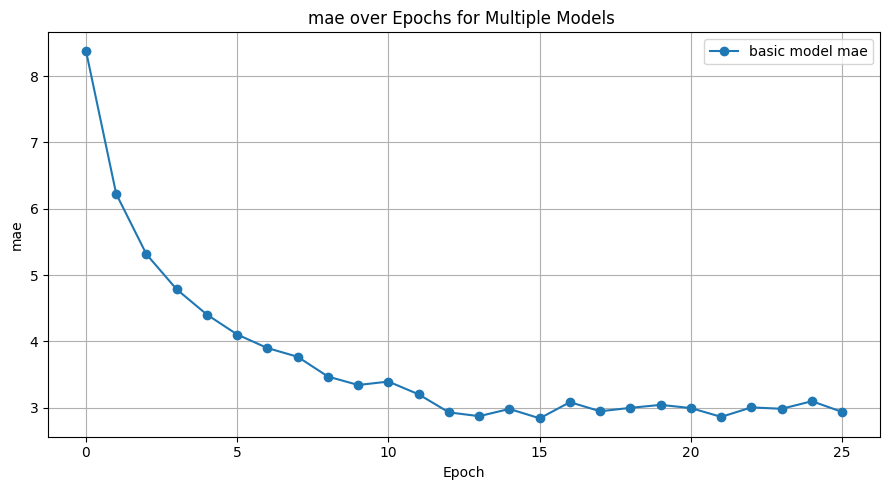

In [24]:
#####TRAINING####
early_stopping = EarlyStopping(patience=10, verbose=True, path="best_model.pt")

model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=1,
    channels=128,
    out_channels=1,  # <-- Adesso 1 output continuo
    aggr="sum",
    norm="batch_norm",
).to(device)

# model.load_state_dict(
#     torch.load("model_pretrained_race_category.pth"),
#     strict=False
# )
# 1. Carica tutto il checkpoint
pretrained_dict = torch.load("model_pretrained_race_category.pth")

# 2. Prendi solo i pesi che non sono della testa
filtered_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('head')}

# 3. Carica i pesi filtrati nel nuovo modello
model.load_state_dict(filtered_dict, strict=False)


loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

epochs = 100
total_steps = epochs * len(loader_dict["train"])
warmup_steps = int(0.1 * total_steps)  # 10% warmup
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
state_dict = None
state_dict_test = None
best_val_metric = -math.inf if higher_is_better else math.inf
best_test_metric = -math.inf if higher_is_better else math.inf
test_table = task.get_table("test", mask_input_cols=False)

#per mantenere la storia dei MAE nel tempo:
val_metr_history = []
test_metr_history = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, scheduler)
    val_pred = test(model, loader_dict["val"])
    #val_metrics = task.evaluate(val_pred, val_table)
    val_metrics = custom_evaluate(val_pred, val_table, task.metrics)

    test_pred = test(model, loader_dict["test"])
    test_metrics = custom_evaluate(test_pred, test_table, task.metrics)

    val_metr_history.append(val_metrics[tune_metric])
    test_metr_history.append(test_metrics[tune_metric])

    print(f"[TRAIN]----Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")
    print(f"[VAL]----Epoch: {epoch:02d}, Val metrics: {val_metrics[tune_metric]}")
    print(f"[TEST]----Epoch: {epoch:02d}, Val metrics: {test_metrics[tune_metric]}")

    early_stopping(val_metrics[tune_metric], model)

    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())

    #test:
    if (higher_is_better and test_metrics[tune_metric] > best_test_metric) or (
            not higher_is_better and test_metrics[tune_metric] < best_test_metric
    ):
        best_test_metric = test_metrics[tune_metric]
        state_dict_test = copy.deepcopy(model.state_dict())


model.load_state_dict(state_dict)
val_pred = test(model, loader_dict["val"])
val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
print(f"Best Val metrics: {val_metrics}")

model.load_state_dict(state_dict_test)
test_pred = test(model,loader_dict["test"])
test_metrics = custom_evaluate(test_pred, test_table, task.metrics)
print(f"Best test metrics: {test_metrics}")

plot_validation_metrics([val_metr_history], ["basic model"],  metric_name=tune_metric)
